In [200]:
from topological_codes import RepetitionCode
from qiskit import Aer, assemble, transpile
import qiskit

import numpy as np

import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

In [201]:
d= 3
xbasis = False

code = RepetitionCode(d,0,xbasis=xbasis)
type(code)
type(code.circuit['0'])

qiskit.circuit.quantumcircuit.QuantumCircuit

In [202]:
code.syndrome_measurement()

In [203]:
q = code.circuit['0'].qregs[1][int(d/2)]
print(q)

Qubit(QuantumRegister(3, 'code_qubit'), 1)


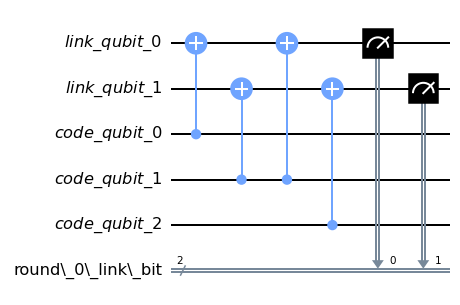

In [93]:
code.circuit['0'].draw('mpl')

In [94]:
rb_opts = {}
rb_opts['length_vector'] = [1,10,20,50,75,100,125,150,175,200]
# num of seeds(random sequences)
rb_opts['nseeds'] = 5
#default pattern
rb_opts['rb_pattern'] = [[0]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [109]:
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        rb_circs[i][j].data
        rb_circs[i][j].data.pop(-1)

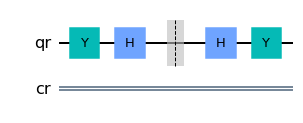

In [111]:
# Randomized benchmarking Gates implementation
rb_circs[1][0].draw('mpl')
# # type(rb_circs[0][0])
# rb_circs[0][0].data #prints the tuple of all the gates applied in the circuit
# rb_circs[0][0].data.pop(-1) #pop the last gate applied i.e. the measurement gate

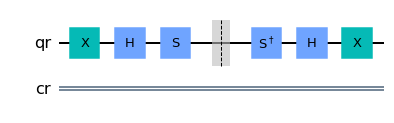

In [64]:
rb_circs[0][0].draw('mpl')

In [127]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
rows, cols = (len(rb_circs), len(rb_circs[0]))
rb_circs_dlist = [[0]*cols]*rows

In [128]:
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        Q= QuantumRegister(5)
        C= ClassicalRegister(1)
        qc = QuantumCircuit(Q,C)
        qq = qc.compose(rb_circs[i][j],[3])
        rb_circs_dlist[i][j] = qq
# All the rb circuits without the measurement part

In [136]:
rb_circs_dlist[0][1]

In [133]:
# Q = QuantumRegister(5)
# C = ClassicalRegister(1)
# qc = QuantumCircuit(Q,C)
# qq = qc.compose(rb_circs[0][0],[3])
# qc.draw('mpl')

In [139]:
code_list = [[0]*cols]*rows
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        d= 3
        xbasis = False
        code = RepetitionCode(d,0,xbasis=xbasis)
        # type(code)
        # type(code.circuit['0'])
        code.syndrome_measurement()
        for logical in ['0','1']:
            code.circuit[logical] = code.circuit[logical].compose(rb_circs_dlist[i][j])
        code.syndrome_measurement()
        code_list[i][j] = code

In [ ]:
qq.draw('mpl')

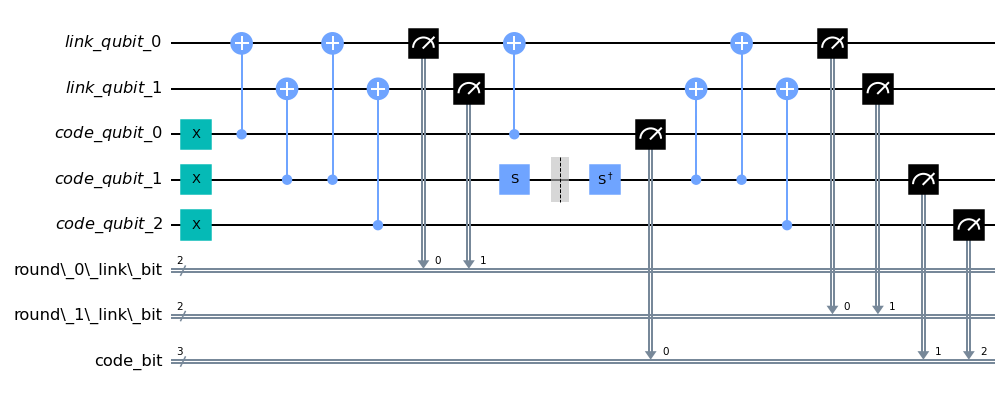

In [145]:
code_list[0][0].circuit['1'].draw('mpl')

In [146]:
# from qiskit import ClassicalRegister, QuantumRegister
# # for logical in ['0','1']:
#     # code.circuit[logical].rx(0.9*np.pi,3)
#     # code.circuit[logical].add_register(ClassicalRegister(3))

# code.circuit['1'].draw('mpl')

In [70]:
# code.syndrome_measurement()

In [147]:
# code.readout()

In [148]:
# code.circuit['0'].draw('mpl')

In [149]:
# code.circuit['0'].draw('mpl')

In [150]:
# code.circuit['1'].draw('mpl')

In [155]:
code_list[0]

In [160]:
backend = Aer.get_backend('aer_simulator')
p_zero = []
p_one = []
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        circuit = code_list[i][j].get_circuit_list()
        job = backend.run(circuit)
        p = {}

        # logical 0
        counts = job.result().get_counts(0)
        if '010 11 00' in counts:
            r = counts['010 11 00']/counts['000 00 00']
            p['0'] = r/(1+r)
        else:
            p['0'] = 0
            
        # logical 1
        counts = job.result().get_counts(1)
        if '101 11 00' in counts:
            r = counts['101 11 00']/counts['111 00 00']
            p['1'] = r/(1+r)
        else:
            p['1'] = 0
            
        # print(p)
        p_zero.append(p['0'])
        p_one.append(p['1'])
        

In [164]:
#Run on noisy simulator

noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.02
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [167]:
backend = Aer.get_backend('aer_simulator')
np_zero = []
np_one = []
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        ncircuit = code_list[i][j].get_circuit_list()
        noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)
        noisy_p = {}
        # logical 0
        noisy_counts = noisy_job.result().get_counts(0)
        if '010 11 00' in noisy_counts:
            noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
            noisy_p['0'] = noisy_r/(1+noisy_r)
        else:
            noisy_p['0'] = 0
            
        # logical 1
        noisy_counts = noisy_job.result().get_counts(1)
        if '101 11 00' in noisy_counts:
            noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
            noisy_p['1'] = noisy_r/(1+noisy_r)
        else:
            noisy_p['1'] = 0
            
        # print(noisy_p)
        np_zero.append(noisy_p['0'])
        np_one.append(noisy_p['1'])

In [168]:
len(np_zero)

50

In [204]:
np_zero

[0.0051334702258726906,
 0.0020898641588296763,
 0.00508646998982706,
 0.003095975232198142,
 0.005122950819672132,
 0.00511770726714432,
 0.009268795056642637,
 0.0031088082901554407,
 0.0071501532175689475,
 0,
 0.004073319755600815,
 0.007209062821833162,
 0.0030643513789581204,
 0.009249743062692703,
 0.006153846153846154,
 0.0072016460905349805,
 0.0051813471502590676,
 0.0020533880903490765,
 0.0030674846625766876,
 0.009193054136874362,
 0.004136504653567735,
 0.005165289256198347,
 0.007246376811594202,
 0.004115226337448559,
 0.0030895983522142125,
 0.009278350515463916,
 0.005107252298263534,
 0.0071574642126789375,
 0.0031185031185031182,
 0.004123711340206186,
 0.004106776180698152,
 0.005102040816326531,
 0.0030612244897959186,
 0.005202913631633715,
 0.006185567010309278,
 0.005091649694501019,
 0.006243496357960458,
 0.010214504596527068,
 0.0040858018386108275,
 0.0031185031185031182,
 0.0031023784901758012,
 0.005170630816959669,
 0.010309278350515462,
 0.0031217481789

No handles with labels found to put in legend.


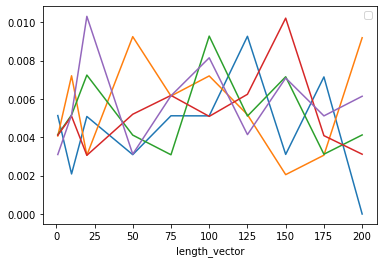

In [213]:
# varying zero and one due to p1q error
fig2 = plt.figure()
plt.plot(rb_opts['length_vector'],np_zero[0:10])
plt.plot(rb_opts['length_vector'],np_zero[10:20])
plt.plot(rb_opts['length_vector'],np_zero[20:30])
plt.plot(rb_opts['length_vector'],np_zero[30:40])
plt.plot(rb_opts['length_vector'],np_zero[40:50])
plt.xlabel('length_vector')
plt.legend()
plt.show()

############ TO BE CHECKED ONCE MORE ##################

In [174]:
code_list[0][0].circuit['0']

In [181]:
rb_circs_zero = [[0]*cols]*rows
#print(len(rb_circs_zero))
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        rb_circs_zero[i][j] = code_list[i][j].circuit['0']

5


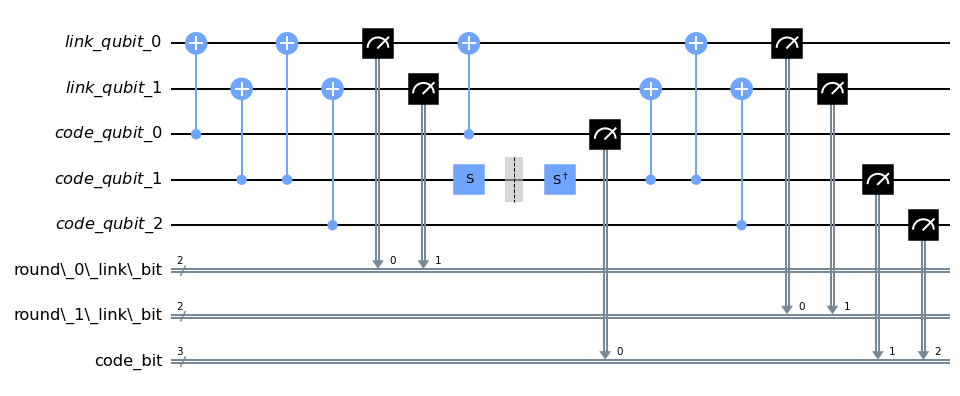

In [199]:
(rb_circs_zero[0][0].draw('mpl'))

In [214]:
rb_circs_zero

[[<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x231c15a5880>,

In [196]:
#verify that the unitary representing each RB circuit is identity using Aer 
from qiskit import QuantumCircuit
nQ = 1
# new circuit without measurement
qregs = rb_circs_zero[0][-1].qregs
cregs = rb_circs_zero[0][-1].cregs
qc = QuantumCircuit(*qregs,*cregs)
for i in rb_circs_zero[0][-1][0:-nQ]:
    qc.data.append(i)
    
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {gate, measure, barrier, save_unitary}, "gates": {cx, s, z, sdg, h, x, y}} is not compatible with any of the automatic simulation methods


QiskitError: 'ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {gate, measure, barrier, save_unitary}, "gates": {cx, s, z, sdg, h, x, y}} is not compatible with any of the automatic simulation methods ,  ERROR: AerSimulator: circuit with instructions {"instructions": {gate, measure, barrier, save_unitary}, "gates": {cx, s, z, sdg, h, x, y}} is not compatible with any of the automatic simulation methods'

In [194]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
print(type(rb_fit))
for rb_seed, rb_circ_seed in enumerate(a):
    print(type(rb_circ_seed))
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

<class 'qiskit.ignis.verification.randomized_benchmarking.fitters.RBFitter'>
<class 'list'>
Compiling seed 0
Simulating seed 0


StopIteration: 

In [78]:
# backend = Aer.get_backend('aer_simulator')
# ncircuit = code.get_circuit_list()
# noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)

In [79]:
# noisy_p = {}

# # logical 0
# noisy_counts = noisy_job.result().get_counts(0)
# if '010 11 00' in noisy_counts:
#     noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
#     noisy_p['0'] = noisy_r/(1+noisy_r)
# else:
#     noisy_p['0'] = 0
    
# # logical 1
# noisy_counts = noisy_job.result().get_counts(1)
# if '101 11 00' in noisy_counts:
#     noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
#     noisy_p['1'] = noisy_r/(1+noisy_r)
# else:
#     noisy_p['1'] = 0
    
# print(noisy_p)

{'0': 0.0010330578512396695, '1': 0.0041025641025641026}


In [80]:
p1q_list = np.linspace(0.0,0.02,num=500)
p2q_list = np.linspace(0.0,0.01,num=500)
zero_list = []
one_list = []
for p1Q,p2Q in zip(p1q_list,p2q_list):
    #Run on noisy simulator

    noise_model = NoiseModel()

    # Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
    # p1Q = 0.02
    # p2Q = 0.01

    # noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    # noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

    backend = Aer.get_backend('aer_simulator')
    ncircuit = code.get_circuit_list()
    noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)

    noisy_p = {}

    # logical 0
    noisy_counts = noisy_job.result().get_counts(0)
    if '010 11 00' in noisy_counts:
        noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
        noisy_p['0'] = noisy_r/(1+noisy_r)
    else:
        noisy_p['0'] = 0
        
    # logical 1
    noisy_counts = noisy_job.result().get_counts(1)
    if '101 11 00' in noisy_counts:
        noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
        noisy_p['1'] = noisy_r/(1+noisy_r)
    else:
        noisy_p['1'] = 0
        
    #print(noisy_p)
    zero_list.append(noisy_p['0'])
    one_list.append(noisy_p['1'])

In [81]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(x=p1q_list,y=zero_list,z=one_list,
                                  marker=dict(
                                      size =4,
                                      colorscale = 'Viridis'
                                  ),
                                  line=dict(
                                      color='darkblue',
                                      width=2
                                  )))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

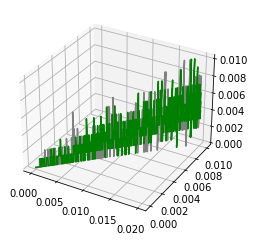

In [82]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
xline = p1q_list
yline = p2q_list
ax.plot3D(xline,yline,zero_list,'gray')
ax.plot3D(xline,yline,one_list,'green')

No handles with labels found to put in legend.


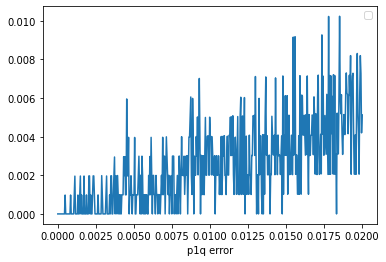

In [83]:
#varying zero and one due to p1q error
fig2 = plt.figure()
plt.plot(p1q_list,zero_list)
plt.xlabel('p1q error')
plt.legend()
plt.show()


No handles with labels found to put in legend.


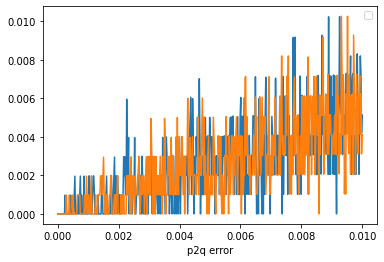

In [84]:
#varying zero and one due to p1q error
fig3 = plt.figure()
plt.plot(p2q_list,zero_list)
plt.xlabel('p2q error')
plt.plot(p2q_list,one_list)
plt.legend()
plt.show()

# RB Fitter Part

In [87]:
mcircuit = code.get_circuit_list()
rb_circs = [mcircuit]
print(rb_circs)

[[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000231A962A070>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000231A981FA90>]]


In [153]:
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
print(type(rb_fit))
for i,rb_circ_seed in enumerate(rb_circs_dlist):
    print(type(rb_circ_seed))
    print(f'Compiling seed {i}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {i}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    print(type(job.result()))
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(i,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

<class 'qiskit.ignis.verification.randomized_benchmarking.fitters.RBFitter'>
<class 'list'>
Compiling seed 0
Simulating seed 0
<class 'qiskit.result.result.Result'>


ValueError: invalid literal for int() with base 10: 'circuit-7383'

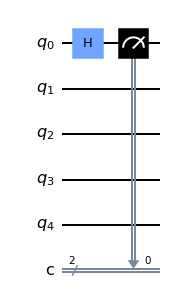

In [221]:
# q1 =QuantumCircuit(5,2)
# q1.h(0)
# q1.measure(0,0)
# q1.draw('mpl')
# from mitiq import zne

In [215]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
print(type(rb_fit))
for rb_seed, rb_circ_seed in enumerate(rb_circs_zero):
    print(type(rb_circ_seed))
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=2)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

<class 'qiskit.ignis.verification.randomized_benchmarking.fitters.RBFitter'>
<class 'list'>
Compiling seed 0
Simulating seed 0


StopIteration: 